In [3]:
import json
import csv
import pandas as pd
from sklearn import preprocessing
import numpy as np
import os
from collections.abc import Sequence
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
import sklearn.feature_extraction.text as sk_text
from sklearn import metrics
import tensorflow.keras 
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
import h5py

from collections import Counter
from datetime import datetime

pd.options.display.max_columns = 200

In [102]:
### HELPER FUNCTIONS ###

def create_hdf5_for_caffe(hdf5_filename, txt_filename, data, labels, name=None, descr=None, shuffle=False):
    print('hello')
        
def hdf5_to_txt(txt_filename , hdf5File):
    with open(txt_filename, mode='w') as txt_file:
        txt_file.writelines([hdf5File])
        
def label_encode_binary(df):
    le = preprocessing.LabelEncoder()
    df['attack'] = le.fit_transform(df['attack'])
    #le.fit(['notAttack','attack'])
    #le.transform(df['attack']) 
    return le.classes_
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()


def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

In [103]:
# Make a pandas dataframe with csv file
df = pd.read_csv('network_intrusion_data.csv', encoding="utf-8")
df.columns = ['duration', 'protocol_type', 'service', 'flag','src_bytes', 'dst_bytes','land', 'wrong_fragment', 
              'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
              'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 
              'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
              'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 
              'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 
              'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 
              'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'outcome']
# print(df.size)

# Drop redundant records
df.drop_duplicates(subset=None, inplace=True)

df.to_csv("education_salary.csv")

# print(df.size)

# Drop records with missing values
df.dropna()



# Add new column for encoding
attackList = []
outcomelist = df['outcome'].tolist()

for item in outcomelist:
    if str(item) == 'normal.':
        attackList.append("notAttack")
    else:
        attackList.append("Attack")

df['attack'] = attackList
            

values = label_encode_binary(df)

        
        
#encode the input for categorical data
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')
encode_text_dummy(df, 'land')
encode_text_dummy(df, 'logged_in')
encode_text_dummy(df, 'is_host_login')
encode_text_dummy(df, 'is_guest_login')
encode_text_index(df, 'outcome')
        

print(df['attack'].dtypes)

int64


In [104]:
encode_numeric_zscore(df, 'count')
encode_numeric_zscore(df, 'srv_count')
encode_numeric_zscore(df, 'src_bytes')
encode_numeric_zscore(df, 'dst_bytes')
encode_numeric_zscore(df, 'dst_host_count')
encode_numeric_zscore(df, 'dst_host_srv_count')

df

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,attack,protocol_type-icmp,protocol_type-tcp,protocol_type-udp,service-IRC,service-X11,service-Z39_50,service-auth,service-bgp,service-courier,service-csnet_ns,service-ctf,service-daytime,service-discard,service-domain,service-domain_u,service-echo,service-eco_i,service-ecr_i,service-efs,service-exec,service-finger,service-ftp,service-ftp_data,service-gopher,service-hostnames,service-http,service-http_443,service-imap4,service-iso_tsap,service-klogin,service-kshell,service-ldap,service-link,service-login,service-mtp,service-name,service-netbios_dgm,service-netbios_ns,service-netbios_ssn,service-netstat,service-nnsp,service-nntp,service-ntp_u,service-other,service-pm_dump,service-pop_2,service-pop_3,service-printer,service-private,service-red_i,service-remote_job,service-rje,service-shell,service-smtp,service-sql_net,service-ssh,service-sunrpc,service-supdup,service-systat,service-telnet,service-tftp_u,service-tim_i,service-time,service-urh_i,service-urp_i,service-uucp,service-uucp_path,service-vmnet,service-whois,flag-OTH,flag-REJ,flag-RSTO,flag-RSTOS0,flag-RSTR,flag-S0,flag-S1,flag-S2,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,0,-0.004261,-0.039036,0,0,0,0,0,0,0,0,0,0,0,0,-0.661636,-0.163049,0.00,0.00,0.0,0.0,1.0,0.0,0.00,-1.639490,-0.967055,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,11,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0
1,0,-0.004263,-0.025041,0,0,0,0,0,0,0,0,0,0,0,0,-0.661636,-0.163049,0.00,0.00,0.0,0.0,1.0,0.0,0.00,-1.538579,-0.879882,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,11,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0
2,0,-0.004272,-0.025041,0,0,0,0,0,0,0,0,0,0,0,0,-0.681569,-0.228118,0.00,0.00,0.0,0.0,1.0,0.0,0.00,-1.437668,-0.792710,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,11,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0
3,0,-0.004273,-0.013612,0,0,0,0,0,0,0,0,0,0,0,0,-0.681569,-0.228118,0.00,0.00,0.0,0.0,1.0,0.0,0.00,-1.336758,-0.705537,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,11,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0
4,0,-0.004273,-0.013612,0,0,0,0,0,0,0,0,0,0,0,0,-0.681569,-0.228118,0.00,0.00,0.0,0.0,1.0,0.0,0.00,-1.235847,-0.618364,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,11,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,-0.004222,-0.016095,0,0,0,0,0,0,0,0,0,0,0,0,-0.701502,-0.260653,0.00

In [106]:
# Encode to a 2D matrix for training
x,y = to_xy(df,'attack')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)



In [107]:

hdf_file = h5py.File('best_weights.hdf5', 'w')


hdf_file.close()




In [108]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')
    
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)




0
Epoch 1/200
3413/3413 - 2s - loss: 0.0511 - val_loss: 0.0255
Epoch 2/200
3413/3413 - 2s - loss: 0.0232 - val_loss: 0.0229
Epoch 3/200
3413/3413 - 2s - loss: 0.0291 - val_loss: 0.0244
Epoch 4/200
3413/3413 - 2s - loss: 0.0214 - val_loss: 0.0243
Epoch 00004: early stopping
1
Epoch 1/200
3413/3413 - 2s - loss: 0.0539 - val_loss: 0.0266
Epoch 2/200
3413/3413 - 2s - loss: 0.0224 - val_loss: 0.0241
Epoch 3/200
3413/3413 - 2s - loss: 0.0215 - val_loss: 0.0233
Epoch 4/200
3413/3413 - 2s - loss: 0.0237 - val_loss: 0.0235
Epoch 00004: early stopping
2
Epoch 1/200
3413/3413 - 2s - loss: 0.0427 - val_loss: 0.0275
Epoch 2/200
3413/3413 - 2s - loss: 0.0424 - val_loss: 0.0248
Epoch 3/200
3413/3413 - 2s - loss: 0.0255 - val_loss: 0.0240
Epoch 4/200
3413/3413 - 2s - loss: 0.0222 - val_loss: 0.0245
Epoch 00004: early stopping
3
Epoch 1/200
3413/3413 - 2s - loss: 0.0378 - val_loss: 0.0261
Epoch 2/200
3413/3413 - 2s - loss: 0.0420 - val_loss: 0.0261
Epoch 3/200
3413/3413 - 2s - loss: 0.0237 - val_loss: 

In [109]:



model.load_weights('best_weights.hdf5') # load weights from best model

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.9981042393603868


[[14393    66]
 [    3 21935]]
Plotting confusion matrix


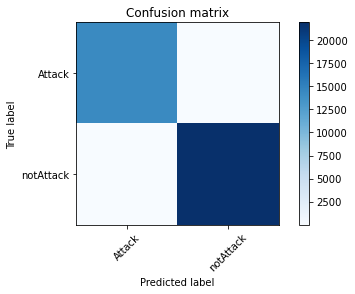

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14459
           1       1.00      1.00      1.00     21938

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [110]:
# Plot a confusion matrix.

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix

cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, values)
plt.show()

print(classification_report(y_true, pred))